Install https://pypi.org/project/ipython-autotime/ or outcomment %load_ext autotime

In [1]:
# %load_ext autotime
import pandas as pd
import xarray as xr
import numpy as np
from mikeio.eum import EUMType, ItemInfo
from fmskill.model import ModelResult
from fmskill.observation import TrackObservation
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# Extract track without having observation as dfs0

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD')
mr.dfs

Dfsu2D
Number of elements: 958
Number of nodes: 570
Projection: LONG/LAT
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)
Time: 67 steps with dt=3600.0s
      2017-10-27 00:00:00 -- 2017-10-29 18:00:00

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
o1 = TrackObservation(df, item=2, name='alti')
o1.itemInfo = ItemInfo(EUMType.Surface_Elevation)    # if TrackObservation is created with a df, itemInfo needs to be added manually

In [5]:
mr.add_observation(o1, item=0)

<AxesSubplot:>

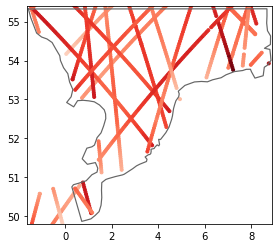

In [6]:
mr.plot_observation_positions()

In [7]:
cc = mr.extract()

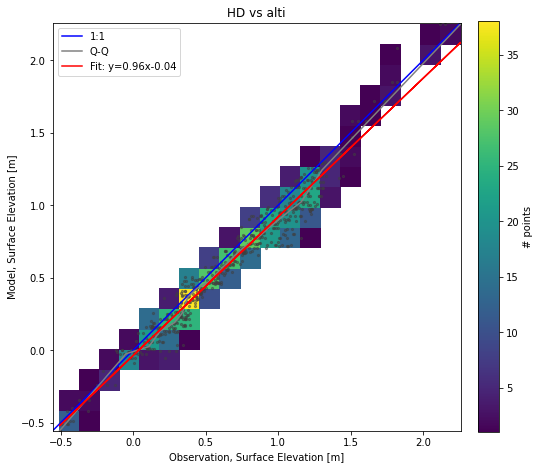

In [8]:
cc['alti'].scatter()

# Extract track from dfs0
ModelResult is now a dfs0

In [9]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ModelResult(fn, name='HD')
mr.dfs

<mikeio.Dfs0>
Timeaxis: TimeAxisType.NonEquidistantCalendar
Items:
  0:  Longitude <Undefined> (undefined)
  1:  Latitude <Undefined> (undefined)
  2:  Model_surface_elevation <Undefined> (undefined)
  3:  Model_wind_speed <Undefined> (undefined)

In [10]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')

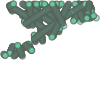

In [11]:
o1.geometry

In [12]:
mr.add_observation(o1, item=2)

c:\users\jem\source\fmskill\fmskill\model.py:106: UserWarning: alti: Cannot validate as type is Undefined.
  warnings.warn(f"{observation.name}: Cannot validate as type is Undefined.")


In [13]:
cc = mr.extract()

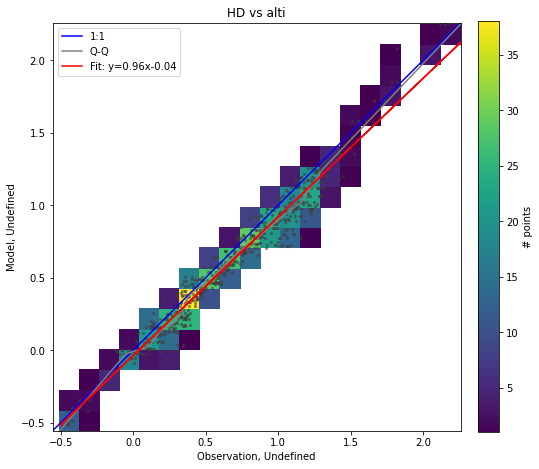

In [14]:
cc['alti'].scatter()

# Spatial skill

Load model, load observation, add observation to model and extract.

In [15]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD')
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')
mr.add_observation(o1, item=0)
cc = mr.extract()

c:\users\jem\source\fmskill\fmskill\model.py:106: UserWarning: alti: Cannot validate as type is Undefined.
  warnings.warn(f"{observation.name}: Cannot validate as type is Undefined.")


Get metrics binned by a regular spatial grid, returns xarray Dataset

In [16]:
ds = cc.spatial_skill(metrics=['bias'])

Plot using xarray - convenient methods coming soon!

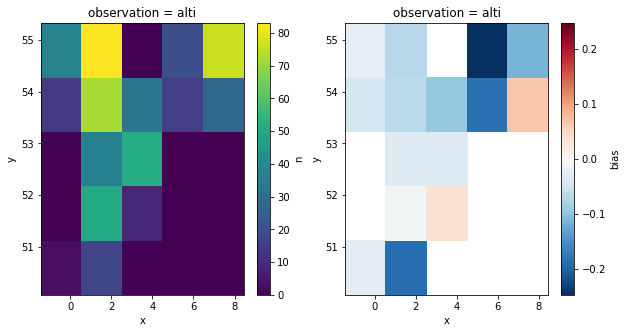

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ds['n'].plot(x='x', y='y', ax=axes[0])
ds['bias'].plot(x='x', y='y', ax=axes[1])

## Minimum number of observations

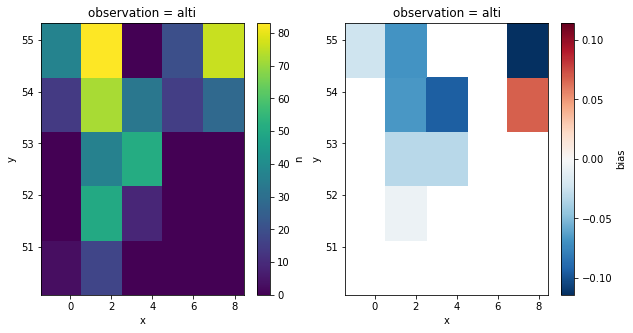

In [18]:
ds = cc.spatial_skill(metrics=['bias'],n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ds['n'].plot(x='x', y='y', ax=axes[0])
ds['bias'].plot(x='x', y='y', ax=axes[1])

## Multiple bins - spatial skill for water level categories

Add water level category to comparer's all_df.

In [19]:
all_df = cc.all_df
all_df['water level'] = 'high'
all_df.loc[all_df['mod_val']<0,'water level'] = 'low'


Pass custom df with water level category to .spatial_skill and select for 'by'.

In [20]:
ds = cc.spatial_skill(by=['water level'],metrics=['bias'],n_min=5)

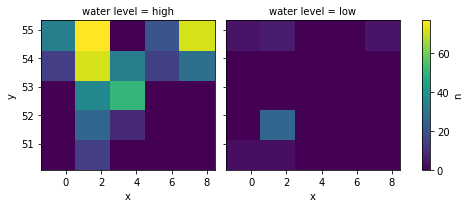

In [21]:
ds['n'].plot(x='x',y='y',col='water level',col_wrap=2)

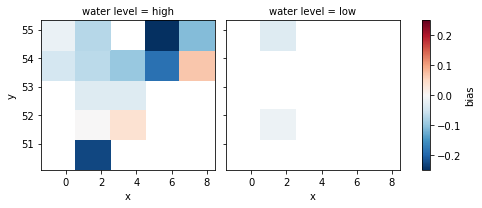

In [22]:
ds['bias'].plot(x='x',y='y',col='water level',col_wrap=2)

## Multiple observations

Add fake 2nd observation to model

In [23]:
df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = TrackObservation(df2, item=2, name='alti2')
mr.add_observation(o2, item=0)

c:\users\jem\source\fmskill\fmskill\model.py:106: UserWarning: alti2: Cannot validate as type is Undefined.
  warnings.warn(f"{observation.name}: Cannot validate as type is Undefined.")


Extract, spatial skill, add attrs, plot.

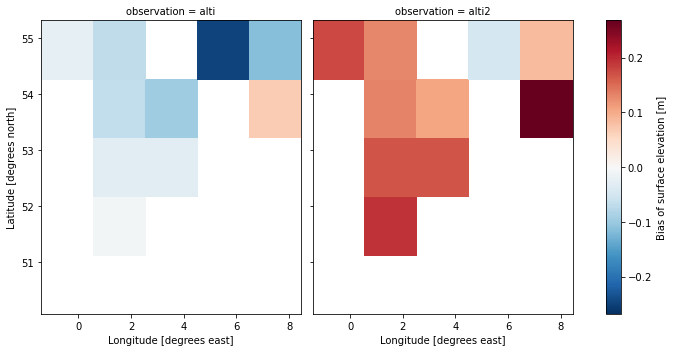

In [24]:
cc = mr.extract()
ds = cc.spatial_skill(metrics=['bias'],n_min=20)
ds['bias'].attrs = dict(long_name="Bias of surface elevation",units="m")
ds['x'].attrs = dict(long_name="Longitude",units="degrees east")
ds['y'].attrs = dict(long_name="Latitude",units="degrees north")
ds['bias'].plot(x='x',y='y',col='observation',col_wrap=2,figsize=(10,5))

# Big data
Run the download.ipynb first

In [25]:
fn = '../data/SW_gwm_3a_extracted_2018.dfs0'
mr = ModelResult(fn, name='GWM')

In [26]:
fn = '../data/altimetry_3a_2018_filter1.dfs0'
o1 = TrackObservation(fn, item=2, name='3a')

In [27]:
mr.add_observation(o1, item=2)

In [28]:
cc = mr.extract()

In [29]:
cc['3a'].skill(end='2018-1-15')

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,372356,-0.475229,0.633093,0.418287,0.510757,0.940399,0.116879,0.968706


In [30]:
cc['3a'].skill()

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,9105364,-0.489382,0.645991,0.421675,0.520273,0.94304,0.11582,0.968518


## Spatial skill

Spatial skill with 1 deg bins and default bin edges.

In [31]:
ds = cc.spatial_skill(metrics=['bias'], bins=(np.arange(-180,180,1), np.arange(-90,90,1)), n_min=20)

Add attrs and plot

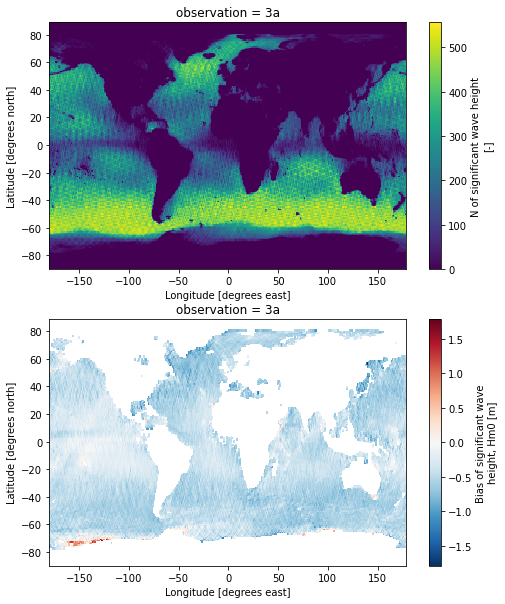

In [32]:
ds['bias'].attrs = dict(long_name="Bias of significant wave height, Hm0",units="m")
ds['n'].attrs = dict(long_name="N of significant wave height",units="-")
ds['x'].attrs = dict(long_name="Longitude",units="degrees east")
ds['y'].attrs = dict(long_name="Latitude",units="degrees north")
fig, axes = plt.subplots(ncols=1, nrows=2, figsize = (8, 10))
ds['n'].plot(x='x', y='y', ax=axes[0])
ds['bias'].plot(x='x', y='y', ax=axes[1])

## Multiple bins - spatial skill for wave height 

Use all_df to obtain and df argument to pass customized data back to comparer.

In [33]:
all_df = cc.all_df.copy()
mean_val = all_df[['mod_val','obs_val']].mean(axis=1)
all_df['val_cat'] = pd.cut(mean_val,[0,2,5,np.inf],labels=["Hm0[m]=[0, 2)","Hm0[m]=[2, 5)","Hm0[m]=[5, inf)"])
all_df.head()

,model,observation,x,y,mod_val,obs_val,xBin,yBin,val_cat
2018-01-01 00:00:00.000000,GWM,3a,-33.706020,23.181158,2.292599,2.611,-33.5,23.5,"Hm0[m]=[2, 5)"
2018-01-01 00:00:01.000005,GWM,3a,-33.720741,23.240074,2.292612,2.608,-33.5,23.5,"Hm0[m]=[2, 5)"
2018-01-01 00:00:01.999999,GWM,3a,-33.735474,23.298990,2.292624,2.518,-33.5,23.5,"Hm0[m]=[2, 5)"
2018-01-01 00:00:03.000004,GWM,3a,-33.750214,23.357904,2.292637,2.729,-33.5,23.5,"Hm0[m]=[2, 5)"
2018-01-01 00:00:03.999998,GWM,3a,-33.764965,23.416819,2.292650,2.593,-33.5,23.5,"Hm0[m]=[2, 5)"


In [34]:
ds = cc.spatial_skill(df=all_df, by=["val_cat"], metrics=["bias"], bins=(np.arange(-180,180,5), np.arange(-90,90,5)), n_min=20)

In [35]:
ds['bias'].attrs = dict(long_name="Bias of significant wave height, Hm0", units="m")
ds['n'].attrs = dict(long_name="N of significant wave height", units="-")
ds['x'].attrs = dict(long_name="Longitude", units="degrees east")
ds['y'].attrs = dict(long_name="Latitude", units="degrees north")
ds['val_cat'].attrs = dict(long_name="Range of sign. wave height, Hm0", units="m")

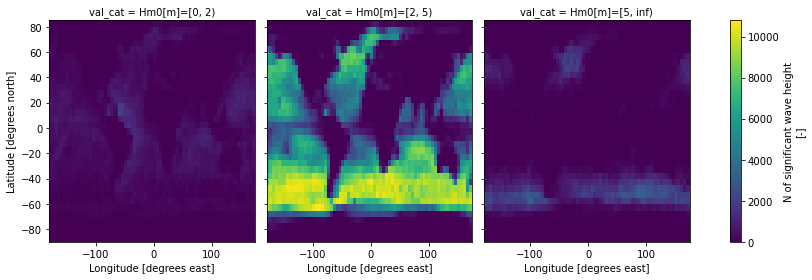

In [36]:
ds['n'].plot(x='x', y='y', col='val_cat', col_wrap=3, figsize=(12,4))

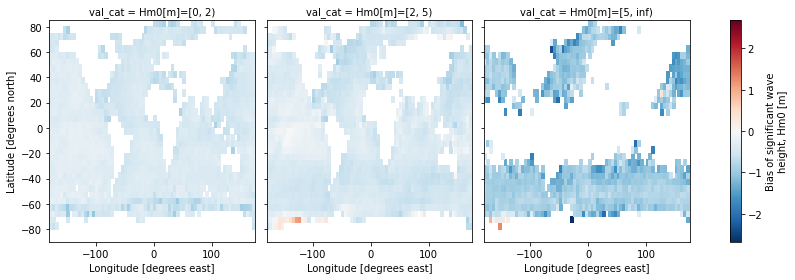

In [37]:
ds['bias'].plot(x='x', y='y', col='val_cat', col_wrap=3, figsize=(12,4))

## Map
http://xarray.pydata.org/en/stable/plotting.html#maps

Requires cartopy: https://scitools.org.uk/cartopy/docs/latest/installing.html